# 3D Inversion of Gravity Anomaly Data use SimPEG

Modified from https://simpeg.xyz/user-tutorials/inv-gravity-anomaly-3d

This example shows a Weighted least-squares inversion for a tensor mesh.

You can also try to run a  Iteratively re-weighted least-squares (IRLS) inversion for a tree mesh

For more information see https://simpeg.xyz/user-tutorials/inv-gravity-anomaly-3d

**Orignial Author:** Devin C. Cowan

</br>

**Keywords:** gravity anomaly, integral formulation, inversion, sparse norm, tensor mesh, tree mesh.

</br>

**Summary:** Here we invert gravity anomaly data to recover a density contrast model. We demonstrate the approache for recovering a density contrast model with a weighted least-squares inversion for a tensor mesh

The *weighted least-squares* approach is a great introduction to geophysical inversion with SimPEG. One drawback however, is that it recovers smooth structures which may not be representative of the true model. Because this tutorial focusses primarily on inversion-related functionality, we urge the reader to become familiar with functionality explained in the [3D Forward Simulation of Gravity Anomaly Data](fwd_gravity_anomaly_3d.ipynb) tutorial before working through this one.

</br>

**Learning Objectives:**

- How geophysical inversion is carried out using SimPEG.
- How to assign appropriate uncertainties to gravity anomaly data.
- How to design a suitable mesh for gravity inversion when using the integral formulation.
- How to choose and set parameters for the inversion.
- How to define directives that are applied and updated throughout the inversion.
- How to applying the sensitivity weighting generally used in 3D gravity inversion.
- How to invert data using weighted least-squares and sparse-norm regularization.
- How to analyse inversion results.

Although we consider gravity anomaly data in this tutorial, the same approach
can be used to invert gravity gradiometry data.

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.
All of the functionality specific to the forward simulation of gravity data are imported from the [simpeg.potential_fields.gravity](myst:simpeg#simpeg.potential_fields.gravity) module. Classes required to define the data misfit, regularization, optimization, etc... are imported from elsewhere within SimPEG. We also import some useful utility functions from [simpeg.utils](myst:simpeg#simpeg.utils). To generate the mesh used for the inversion, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from simpeg.potential_fields import gravity
from simpeg.utils import plot2Ddata, model_builder, download
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

# discretize functionality
from discretize import TensorMesh, TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import griddata
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
import pandas as pd
mpl.rcParams.update({"font.size": 14})

## Load Data Files

For most geophysical inversion projects, a reasonable inversion result can be obtained so long as the practitioner has observed data and topography. For this tutorial, we use the residual gravity from our last notebook.

In [2]:
Data = pd.read_csv('Topo_Free_Grav_CAGE_FIELD.csv', delimiter=r',')

In [3]:
Data

,Lon,Lat,Easting,Northing,Height_Ellipsoid,Height_Sealevel,Total Gravity,Free Air Disturbance,Topo Free Disturbance
0,116.221272,-31.521204,426064.250379,6.512371e+06,206.730,235.60,1.494362,-2.183071,-45.699006
1,116.221281,-31.520428,426064.531384,6.512457e+06,209.068,237.94,1.547080,-1.346266,-45.958914
2,116.220166,-31.521275,425959.314082,6.512362e+06,217.752,246.63,0.230452,-0.050988,-47.495031
3,116.220229,-31.520332,425964.523246,6.512467e+06,216.532,245.41,1.126149,0.544137,-46.635521
4,116.219096,-31.521241,425857.694051,6.512365e+06,221.841,250.72,-0.506791,0.476491,-48.201120
5,116.219187,-31.520341,425865.623188,6.512465e+06,219.737,248.62,0.322696,0.729118,-47.166019
6,116.218134,-31.521266,425766.403107,6.512362e+06,222.158,251.05,-0.726197,0.352938,-48.787989
7,116.217021,-31.521264,425660.735553,6.512361e+06,221.151,250.05,-0.601907,0.166561,-48.571555
8,116.215931,-31.521243,425557.236543,6.512363e+06,222.021,250.92,-0.738277,0.300363,-48.617853
9,116.214864,-31.521226,425455.867256,6.512364e+06,219.538,248.45,-0.048972,0.224710,-47.275689


In [4]:
Data['Topo Free Disturbance'].mean()

-48.50408448131283

In [5]:
dobs = np.column_stack((Data['Easting'], Data['Northing'], Data['Height_Sealevel'], Data['Topo Free Disturbance']-Data['Topo Free Disturbance'].mean()))


In [6]:
dobs

array([[ 4.26064250e+05,  6.51237053e+06,  2.35600000e+02,
         2.80507873e+00],
       [ 4.26064531e+05,  6.51245659e+06,  2.37940000e+02,
         2.54517076e+00],
       [ 4.25959314e+05,  6.51236192e+06,  2.46630000e+02,
         1.00905390e+00],
       [ 4.25964523e+05,  6.51246652e+06,  2.45410000e+02,
         1.86856394e+00],
       [ 4.25857694e+05,  6.51236498e+06,  2.50720000e+02,
         3.02964418e-01],
       [ 4.25865623e+05,  6.51246483e+06,  2.48620000e+02,
         1.33806576e+00],
       [ 4.25766403e+05,  6.51236160e+06,  2.51050000e+02,
        -2.83904411e-01],
       [ 4.25660736e+05,  6.51236101e+06,  2.50050000e+02,
        -6.74709314e-02],
       [ 4.25557237e+05,  6.51236256e+06,  2.50920000e+02,
        -1.13768826e-01],
       [ 4.25455867e+05,  6.51236371e+06,  2.48450000e+02,
         1.22839582e+00],
       [ 4.25356979e+05,  6.51236573e+06,  2.43640000e+02,
         1.07643968e+00],
       [ 4.25260029e+05,  6.51236379e+06,  2.42720000e+02,
      

## Plot Observed Data and Topography

Here we plot the synthetic gravity anomaly data and local topography.

In [7]:
# Define receiver locations and observed data
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

In [8]:
np.max(np.abs(dobs))

3.1203670768564393

C:\Users\li353\AppData\Local\Temp\ipykernel_20648\726880059.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


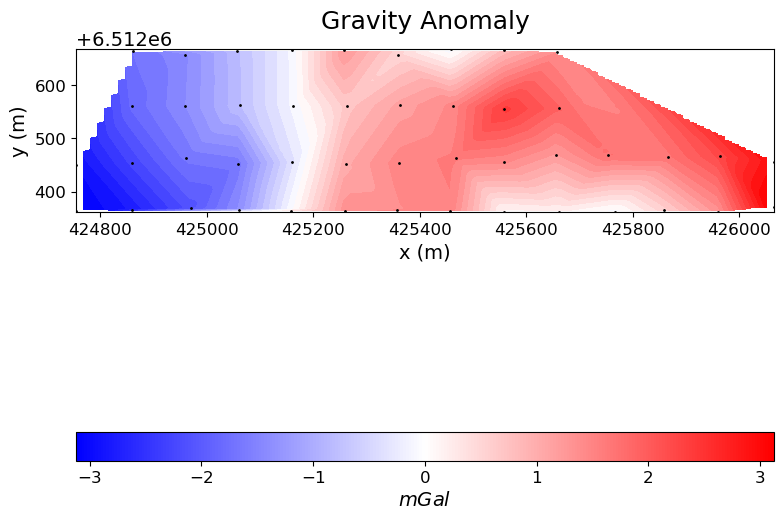

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[20, 1], hspace=0.05)

# Main plot
ax1 = fig.add_subplot(gs[0])
plot2Ddata(
    receiver_locations,
    dobs,
    ax=ax1,
    dataloc=True,
    ncontour=40,
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("Gravity Anomaly", fontsize=18, pad=15)
ax1.set_xlabel("x (m)", fontsize=14)
ax1.set_ylabel("y (m)", fontsize=14)
ax1.tick_params(labelsize=12)

# Colorbar
cx1 = fig.add_subplot(gs[1])
norm1 = mpl.colors.Normalize(vmin=-np.max(np.abs(dobs)), vmax=np.max(np.abs(dobs)))
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm1, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$mGal$", size=14)
cbar1.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

## Assign Uncertainties

Inversion with SimPEG requires that we define the uncertainties on our data; that is, an estimate of the standard deviation of the noise on our data assuming it is uncorrelated Gaussian with zero mean. An online resource explaining uncertainties and their role in the inversion can be found [here](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).

**For gravity anomaly data,** a constant floor value is generally applied to all data. We usually avoid assigning percent uncertainties because the inversion would prioritize fitting the background over fitting anomalies. The floor value for the uncertainties may be chosen based on some knowledge of the instrument error, or it may be chosen as some fraction of the largest anomaly value. For this tutorial, the floor uncertainty assigned to all data is 2.5% of the maximum observed gravity anomaly value. **For gravity gradiometry data,** you may choose to assign a different floor value to each data component.

In [10]:
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.002
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))

Floor uncertainty: 0.002


## Define the Survey

Here, we define the survey geometry. For a more comprehensive description of constructing gravity surveys in SimPEG, see the [3D Forward Simulation of Gravity Anomaly Data](fwd_gravity_anomaly_3d.ipynb) tutorial.

In [11]:
# Define the receivers. The data consist of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")
receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

## Define the Data

The SimPEG [Data](myst:simpeg#simpeg.data.Data) class is required for inversion and connects the observed data, uncertainties and survey geometry.

In [12]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

## Weighted Least-Squares Inversion on a Tensor Mesh

Here, we provide a step-by-step best-practices approach for weighted least-squares inversion of gravity anomaly data.

### Design a (Tensor) Mesh

Meshes are designed using the [discretize package](https://discretize.simpeg.xyz). Here, we design a [tensor mesh](myst:discretize#discretize.TensorMesh). See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating meshes. When designing a mesh for gravity inversion, we must consider the spatial wavelengths of the signals contained within the data. If the data spacing is large and/or the signals present in the data are smooth, larger cells can be used to construct the mesh. If the data spacing is smaller and compact anomalies are observed, smaller cells are needed to characterize the structures responsible. And smaller cells are required when the effects of surface topography are significant.

**General rule of thumb:** The minimum cell size in each direction is at most 0.5 - 1 times the station spacing. And the thickness of the padding is at least 1 - 2 times the width of the survey region.

In [13]:
# Generate tensor mesh with top at z = 0 m
dh = 25.0  # minimum cell size
hx = [(dh, 2, -1.4), (dh, 66), (dh, 2, 1.4)]  # discretization along x
hy = [(dh, 2, -1.4), (dh, 20), (dh, 2, 1.4)]  # discretization along y
hz = [(dh, 5, -1.25), (dh/2, 30)]  # discretization along z
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

# Shift vertically to top same as maximum topography
tensor_mesh.origin += np.r_[Data.Easting.mean(), Data.Northing.mean(), Data.Height_Ellipsoid.min()]

### Mapping from the Model to Active Cells

In SimPEG, the term 'model' is not synonymous with the physical property values defined on the mesh. For whatever model we choose, we must define a mapping from the set of model parameters (a [1D numpy.ndarray](myst:numpy#numpy.ndarray)) to the active cells in the mesh. Mappings are created using the [simpeg.maps](myst:simpeg#simpeg.maps.IdentityMap) module. For the tutorial exercise, the model is the density contrast values for all active cells. As such, our mapping is an identity mapping, whose dimensions are equal to the number of active cells.

In [14]:

active_tensor_cells  = active_from_xyz(tensor_mesh, receiver_locations)

n_tensor_active = int(active_tensor_cells.sum())


tensor_model_map = maps.IdentityMap(nP=n_tensor_active)



### Starting/Reference Models

The **starting model** defines a reasonable starting point for the inversion and does not necessarily represent an initial estimate of the true model. Because the integral formulation used to solve the gravity forward simulation is linear, the optimization problem we must solve is a linear least-squares problem, making the choice in starting model insignificant. It should be noted that the starting model **cannot be vector of zeros,** otherwise the inversion will be unable to compute a gradient direction at the first iteration. For gravity inversion, the starting model is frequently a constant vector with a very small value.

The **reference model** is used to include a-prior information. The impact of the reference model on the inversion will be discussed in another tutorial. Assuming the contribution from all background structures has been removed from the gravity anomaly data, and assuming we have not a-priori information, the reference model for basic inversion of gravity data is zero.

Notice that the length of the starting and reference models is equal to the number of active mesh cells!!!

In [15]:
starting_tensor_model = 1e-6 * np.ones(n_tensor_active)
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [16]:
# Map for ignoring inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(tensor_mesh, active_tensor_cells, np.nan)

In [17]:
tensor_mesh

TensorMesh: 58,800 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     70    424,442.43    426,260.43     25.00     49.00    1.40
   y     24  6,512,156.12  6,512,824.12     25.00     49.00    1.40
   z     35       -424.74        206.73     12.50     76.29    2.50

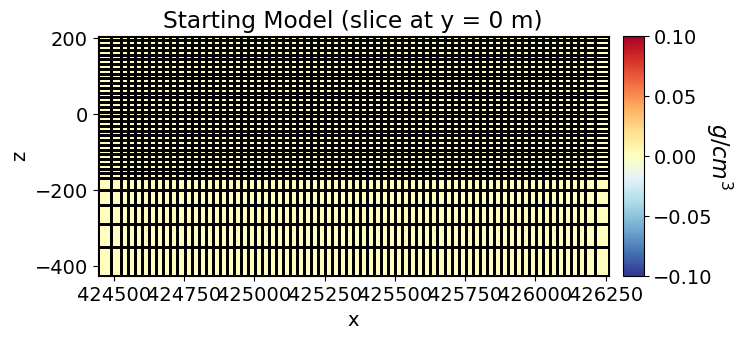

In [18]:
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.1)
tensor_mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

### Define the Forward Simulation

A simulation object defining the forward problem is required in order to predict data and calculate misfits for recovered models. A comprehensive description of the simulation object for gravity anomaly data was discussed in the [3D Forward Simulation of Gravity Anomaly Data](fwd_gravity_anomaly_3d.ipynb) tutorial. Here, we use the [3D integral formulation](myst:simpeg#simpeg.potential_fields.gravity.simulation.Simulation3DIntegral).

In [19]:
simulation_L2 = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tensor_mesh,
    rhoMap=tensor_model_map,
    ind_active=active_tensor_cells,
    engine="geoana",
)

:::{tip}
By choosing `engine="choclo"` we can make our simulation to run the faster and more memory efficient implementation of the gravity forward that uses [Numba](https://numba.pydata.org/) and [Choclo](https://www.fatiando.org/choclo) under the hood. To do so, we need to have [Choclo installed](https://www.fatiando.org/choclo/latest/install.html).
:::

### Define the Data Misfit

To understand the role of the data misfit in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).
Here, we use the [L2DataMisfit](myst:simpeg#simpeg.data_misfit.L2DataMisfit) class to define the data misfit. In this case, the data misfit is the L2 norm of the weighted residual between the observed data and the data predicted for a given model. When instantiating the data misfit object within SimPEG, we must assign an appropriate *data object* and *simulation object* as properties.

In [20]:
dmis_L2 = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_L2)

### Define the Regularization

To understand the role of the regularization in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/ObjectiveFunction.html). Here, we use the [WeightedLeastSquares](myst:simpeg#simpeg.regularization.WeightedLeastSquares) regularization class to constrain the inversion result. Here, length scales along x, y and z are used to balance the smallness and smoothness terms. And the reference model is only applied to the smallness term; which is redundant for the tutorial example since we have set the reference model to an array of zeros.

In [21]:
reg_L2 = regularization.WeightedLeastSquares(
    tensor_mesh,
    active_cells=active_tensor_cells,
    length_scale_x=1.0,
    length_scale_y=1.0,
    length_scale_z=1.0,
    reference_model=reference_tensor_model,
    reference_model_in_smooth=False,
)

### Define the Optimization Algorithm

Here, we use the [InexactGaussNewton](myst:simpeg#simpeg.optimization.InexactGaussNewton) class to solve the optimization problem using inexact Gauss-Newton. Reasonable default values have generally been set for the properties of each optimization class. However, the user may choose to set custom values; e.g. the accuracy tolerance for the conjugate gradient solver or the number of line searches.

In [22]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

### Define the Inverse Problem

We use the [BaseInvProblem](myst:simpeg#simpeg.inverse_problem.BaseInvProblem) class to fully define the inverse problem that is solved at each beta (trade-off parameter) iteration. The inverse problem requires appropriate *data misfit*, *regularization* and *optimization* objects.

In [23]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

### Provide Inversion Directives

Directives represent operations that are carried out during the inversion. Here, we apply common directives for weighted least-squares inversion of gravity data and describe their roles. These are:

- [UpdateSensitivityWeights](myst:simpeg#simpeg.directives.UpdateSensitivityWeights): Apply sensitivity weighting to counteract the natural tendancy of potential field inversion to cluster recovered structures near the receivers. Because the 3D integral formulation is linear, the sensitivity weighting is independent of the model and does not need to be updated throughout the inversion, so we set `every_iteration=False`.

- [UpdatePreconditioner](myst:simpeg#simpeg.directives.UpdatePreconditioner): Apply Jacobi preconditioner when solving optimization problem.

- [BetaEstimate_ByEig](myst:simpeg#simpeg.directives.BetaEstimate_ByEig): Compute and set starting trade-off parameter (beta) based on largest eigenvalues.

- [BetaSchedule](myst:simpeg#simpeg.directives.BetaSchedule): Size reduction of the trade-off parameter at every beta iteration, and the number of Gauss-Newton iterations for each beta.

- [TargetMisfit](myst:simpeg#simpeg.directives.TargetMisfit): Terminates the inversion when the data misfit equals the target misfit. A `chifact=1` terminates the inversion when the data misfit equals the number of data.


The directive objects are organized in a ``list``. Upon starting the inversion or updating the recovered model at each iteration, the inversion will call each directive within the list **in order**. The order of the directives matters, and SimPEG will throw an error if directives are organized into an improper order. Some directives, like the ``BetaEstimate_ByEig`` are only used when starting the inversion. Other directives, like ``UpdatePreconditionner``, are used whenever the model is updated.

In [24]:
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

### Define and Run the Inversion

We define the inversion using the [BaseInversion](myst:simpeg#simpeg.inversion.BaseInversion) class. The inversion class must be instantiated with an appropriate *inverse problem* object and *directives list*. The ``run`` method, along with a starting model, is respondible for running the inversion. The output is a 1D numpy.ndarray containing the recovered model parameters

In [25]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run inversion
recovered_tensor_model = inv_L2.run(starting_tensor_model)


Running inversion with SimPEG v0.22.2

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.02e+01  2.52e+07  2.97e-05  2.52e+07    1.24e+06      0              
   1  1.01e+01  7.54e+06  2.73e+05  1.03e+07    2.86e+05      0              
   2  5.04e+00  4.50e+06  4.85e+05  6.95e+06    1.96e+05      0   Skip BFGS  
   3  2.52e+00  2.59e+06  7.52e+05  4.48e+06    1.27e+05      0   Skip BFGS  
   4  1.26e+00  1.44e+06  1.07e+06  2.79e+06    7.96e+04      0   Skip BFGS  
   5  6.30e-01  7.70e+05  1.44e+06  1.68e+06    4.89e+04      0   Skip BFGS  
   6  3.15e-01  3.85e+0

### Plot the Data Misfit

This step is necessary for determining whether the recovered model accurately reproduces observed anomalies. Here, we plot the observed data, predicted data for the recovered model, and the misfit. As we can see, the predicted data fits the background somewhat better than the anomalies. As a result, you may reassign smaller uncertainties in these areas and re-run the inversion in order to better fit the anomalies. We will do this for the iteratively reweighted least-squares inversion.

In [ ]:
# Predicted data with final recovered model.
dpred = inv_prob_L2.dpred

# Observed data | Predicted data | Data misfit
data_array = np.c_[dobs, dpred, dobs - dpred]

fig = plt.figure(figsize=(12, 5))
plot_title = ["Observed", "Predicted", "Data Misfit"]
plot_units = ["mGal", "mGal", "mGal"]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max((dobs)), np.max((dobs)), np.max(np.abs(dobs - dpred))]
v_liml = [np.min((dobs)), np.min((dobs)), -np.max(np.abs(dobs - dpred))]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.3 * ii + 0.1, 0.2, 0.27, 0.75])
    norm[ii] = mpl.colors.Normalize(vmin=v_liml[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    if ii == 0:
        ax1[ii].set_ylabel("y (m)")
    else:
        ax1[ii].set_yticks([])

    ax2[ii] = fig.add_axes([0.3 * ii + 0.1, 0.05, 0.27, 0.05])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].ax.locator_params(nbins=3)
    cbar[ii].set_label(plot_units[ii], labelpad=5)

plt.show()

### Plot the Recovered Model

As we can see, weighted least-squares regularization leads to the recovery of smooth models. And even with sensitivity weighting, there is a tendancy for gravity anomaly inversion to place recovered structures near the Earth's surface.

## Important, In SimPEG the vertical direction is positive up, and normally we define gravity as positive down, so we need to invert the sign of our density

In [ ]:
recovered_tensor_model=-recovered_tensor_model

In [ ]:
import ipywidgets as widgets
from IPython.display import display


# Define the function to plot with a specific slice index in the "Y" direction
def plot_recovered_model_y(ind):
    fig = plt.figure(figsize=(7, 3))
    ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

    norm = mpl.colors.Normalize(
        vmin=np.min(recovered_tensor_model), vmax=np.max(recovered_tensor_model)
    )
    
    # Plot the slice with the chosen index in the "Y" direction
    tensor_mesh.plot_slice(
        tensor_plotting_map * recovered_tensor_model,
        normal="Y",
        ax=ax1,
        ind=ind,
        grid=False,
        pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
    )
    
    ax1.set_title(f'Model slice at y = {tensor_mesh.nodes_y[ind]/1000} km')
    
    ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
    cbar = mpl.colorbar.ColorbarBase(
        ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
    )
    cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)
    
    plt.show()

# Create an interactive widget for selecting the index
slice_slider_y = widgets.IntSlider(
    value=int(tensor_mesh.shape_cells[1] / 2),
    min=0,
    max=tensor_mesh.shape_cells[1] - 1,
    step=1,
    description='Slice Index Y:',
    continuous_update=False
)

# Link the interactive widget with the function and display
interactive_plot = widgets.interactive(plot_recovered_model_y, ind=slice_slider_y)
display(interactive_plot)


In [ ]:
# Define the function to plot with a specific slice index
def plot_recovered_model(ind):
    fig = plt.figure(figsize=(13, 5))
    ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

    norm = mpl.colors.Normalize(
        vmin=np.min(recovered_tensor_model)/3*2, vmax=np.max(recovered_tensor_model)/3*2
    )
    
    # Plot the slice with the chosen index
    tensor_mesh.plot_slice(
        tensor_plotting_map * recovered_tensor_model,
        normal="Z",
        ax=ax1,
        ind=ind,
        grid=False,
        pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
    )
    plt.scatter(receiver_locations[:,0],receiver_locations[:,1],color='k',s=0.1)

    
    ax1.set_title(f'Horizontal slice Z = {tensor_mesh.nodes_z[ind]} m')
    
    ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
    cbar = mpl.colorbar.ColorbarBase(
        ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
    )
    cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)
    plt.show()

# Create an interactive widget for selecting the index
slice_slider = widgets.IntSlider(
    value=int(tensor_mesh.shape_cells[2] / 2) - 1,
    min=0,
    max=tensor_mesh.shape_cells[2] - 1,
    step=1,
    description='Slice Index:',
    continuous_update=False
)

# Display the interactive plot
widgets.interactive(plot_recovered_model, ind=slice_slider)

In [ ]:
plot_recovered_model_y(12)

In [ ]:
plot_recovered_model(25)

In [ ]:
# Save model for visulization in geoscience analyst
tensor_mesh.write_UBC('density_model.msh',{'density_model.den': recovered_tensor_model})